# `Fuzzy_Instr` feature for identification of potentially vulnerability functions (using CB-Multios Binaries)

Uses output from Ghidra headless, BinExport, and BinDiff to identify functions in CB-Multios Binaries modified during the patch. 

1. Generate labels- Assume modified function was vulnerable in the original version, but is not vulnerable in the patched version

2. Create models- Train supervised learning models using the `fuzzy_instr` for each function (`Doc2Vec` and `FastText`), use 80:20 split (train:test)

3. Data imbalance- Use random oversampling and random undersampling to balance the dataset and observe impacts to models/predictions

4. Assess- Assess the models using original data labels and Test set

# Imports

In [9]:
#Misc
import os
from ast import literal_eval
import re
import smart_open
import time
from datetime import date

# Analysis (Pandas & Numpy)
import pandas as pd
from pandas import DataFrame
import numpy as np

# Learning Models
from gensim.models import Doc2Vec
import gensim
import fasttext

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Load Initial data

In [7]:
path = os.getcwd() 
print(path)

/Volumes/Research/VulnerabilityDatasets/Vulnerability_datasets/code/ghidra/ghidra_extractions-main


## BinDiff Data

Using a `.csv` generated during the Ghidra headless, and Auto BinExport/BinDiff steps described [here](https://github.com/Kayla0x41/ghidraheadless_binexport)

In [3]:
bindiff_df = pd.read_csv(path+'/cb_bindiff_data/cbmultios_BinExports/resources/final_combined/final_combined.csv', index_col=[0])

In [4]:
bindiff_df.head()

,id,address1,address2,similarity,confidence,flags,algorithm,evaluate,commentsported,basicblocks,edges,instructions,original_sample,patched_sample,orig_fun_name,patched_fun_name
index,,,,,,,,,,,,,,,,
0,1,134520832,134520832,1.0,0.993307,0,1,0,0,3,3,12,Messaging_2,Messaging_2_patched,_init,_init
1,2,134520880,134520880,1.0,0.982014,0,1,0,0,1,1,2,Messaging_2,Messaging_2_patched,FUN_0804a030,FUN_0804a030
2,3,134520896,134520896,1.0,0.982014,0,1,0,0,1,0,1,Messaging_2,Messaging_2_patched,operator.new,operator.new
3,4,134520912,134520912,1.0,0.982014,0,1,0,0,1,0,1,Messaging_2,Messaging_2_patched,cgc_receive,cgc_receive
4,5,134520928,134520928,1.0,0.982014,0,1,0,0,1,0,1,Messaging_2,Messaging_2_patched,operator.new[],operator.new[]


In [5]:
bindiff_df.query('orig_fun_name != patched_fun_name').query('similarity < 1.0')

,id,address1,address2,similarity,confidence,flags,algorithm,evaluate,commentsported,basicblocks,edges,instructions,original_sample,patched_sample,orig_fun_name,patched_fun_name
index,,,,,,,,,,,,,,,,
83,84,134529744,134528656,0.180708,0.377541,19,15,0,0,1,0,16,greeter,greeter_patched,cgc_md5_sig,md5_hmac_sig


There is a single example where the original and patched function names differ and their content is < 1.0 similar. We'll need to handle this as a special case. 

## Ghidra Headless extractions

Using a `.csv` generated during the Ghidra headless extraction described [here](https://github.com/Kayla0x41/ghidra_extractions)

In [6]:
ghidra_df = pd.read_csv('cb_multios_ghidra_filelevel_istructions_22April21.csv', header=None)

In [7]:
ghidra_df.columns = ['sample_name', 'fun_name', 'cc', 'fun_instr']
ghidra_df

,sample_name,fun_name,cc,fun_instr
0,3D_Image_Toolkit,_init,2,"[u'ENDBR32', u'PUSH EBX', u'SUB ESP,0x8', u'CA..."
1,3D_Image_Toolkit,FUN_0804a030,0,"[u'PUSH dword ptr [0x0805158c]', u'JMP dword p..."
2,3D_Image_Toolkit,cgc_pow,1,[u'JMP dword ptr [0x08051594]']
3,3D_Image_Toolkit,cgc__terminate,1,[u'JMP dword ptr [0x08051598]']
4,3D_Image_Toolkit,cgc_transmit,1,[u'JMP dword ptr [0x0805159c]']
...,...,...,...,...
57066,yolodex_patched,main,0,"[u'PUSH EBP', u'MOV EBP,ESP', u'SUB ESP,0x18',..."
57067,yolodex_patched,__libc_csu_init,3,"[u'ENDBR32', u'PUSH EBP', u'CALL 0x0804c065', ..."
57068,yolodex_patched,__libc_csu_fini,1,"[u'ENDBR32', u'RET']"
57069,yolodex_patched,__x86.get_pc_thunk.bp,1,"[u'MOV EBP,dword ptr [ESP]', u'RET']"


## Correlate DataFrames (using sample and function names)

In [8]:
bindiff_df_cpy = bindiff_df.copy()
bindiff_df_cpy.columns

Index(['id', 'address1', 'address2', 'similarity', 'confidence', 'flags',
       'algorithm', 'evaluate', 'commentsported', 'basicblocks', 'edges',
       'instructions', 'original_sample', 'patched_sample', 'orig_fun_name',
       'patched_fun_name'],
      dtype='object')

In [9]:
bindiff_df_cpy.columns = ['id', 'address1', 'address2', 'similarity', 'confidence', 'flags',
       'algorithm', 'evaluate', 'commentsported', 'basicblocks', 'edges',
       'instructions', 'sample_name', 'patched_sample', 'fun_name',
       'patched_fun_name']

In [10]:
merge_1 = pd.merge(ghidra_df, bindiff_df_cpy, on=['sample_name', 'fun_name'])

In [11]:
merge_1.columns = ['orig_sample_name', 'orig_fun_name', 'cc', 'fun_instr', 'id', 'address1',
       'address2', 'similarity', 'confidence', 'flags', 'algorithm',
       'evaluate', 'commentsported', 'basicblocks', 'edges', 'instructions',
       'sample_name', 'fun_name']

In [12]:
merge_2 = pd.merge(ghidra_df, merge_1, on=['sample_name', 'fun_name'])

In [13]:
merge_2.columns = ['patched_sample_name', 'patched_fun_name', 'orig_cc', 'orig_fun_instr', 'orig_sample_name',
       'orig_fun_name', 'patched_cc', 'patched_fun_instr', 'id', 'address1', 'address2',
       'similarity', 'confidence', 'flags', 'algorithm', 'evaluate',
       'commentsported', 'basicblocks', 'edges', 'instructions']

In [14]:
merge_2['original_vulnerable'] = merge_2['similarity'].apply(lambda x: True if x < 1.0 else False)

In [15]:
merge_2.original_vulnerable.value_counts()

False    67977
True       888
Name: original_vulnerable, dtype: int64

In [29]:
original_samples = merge_2[['orig_sample_name', 'orig_fun_name', 'orig_fun_instr', 'original_vulnerable']]

In [30]:
original_samples.columns = ['sample_name', 'fun_name', 'fun_instr', 'vulnerable']

In [31]:
original_samples

,sample_name,fun_name,fun_instr,vulnerable
0,3D_Image_Toolkit,FUN_0804a030,"[u'PUSH dword ptr [0x0805158c]', u'JMP dword p...",False
1,3D_Image_Toolkit,cgc_pow,[u'JMP dword ptr [0x08051594]'],False
2,3D_Image_Toolkit,cgc_pow,[u'JMP dword ptr [0x08051594]'],False
3,3D_Image_Toolkit,cgc__terminate,[u'JMP dword ptr [0x08051598]'],False
4,3D_Image_Toolkit,cgc__terminate,[u'JMP dword ptr [0x08051598]'],False
...,...,...,...,...
68860,yolodex,main,"[u'PUSH EBP', u'MOV EBP,ESP', u'SUB ESP,0x18',...",False
68861,yolodex,__libc_csu_init,"[u'ENDBR32', u'PUSH EBP', u'CALL 0x0804c065', ...",False
68862,yolodex,__libc_csu_fini,"[u'ENDBR32', u'RET']",False
68863,yolodex,__x86.get_pc_thunk.bp,"[u'MOV EBP,dword ptr [ESP]', u'RET']",False


In [39]:
original_samples.vulnerable.value_counts()

False    67977
True       888
Name: vulnerable, dtype: int64

In [32]:
patched_samples = merge_2[['patched_sample_name', 'patched_fun_name', 'patched_fun_instr', 'original_vulnerable']]

In [33]:
patched_samples.columns = ['sample_name', 'fun_name', 'fun_instr', 'vulnerable']

In [40]:
patched_samples['vulnerable'] = False

<ipython-input-40-c74e0c11e8b4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patched_samples['vulnerable'] = False


In [41]:
frames = [original_samples, patched_samples]

In [42]:
final = pd.concat(frames, ignore_index=True)

In [43]:
final

,sample_name,fun_name,fun_instr,vulnerable
0,3D_Image_Toolkit,FUN_0804a030,"[u'PUSH dword ptr [0x0805158c]', u'JMP dword p...",False
1,3D_Image_Toolkit,cgc_pow,[u'JMP dword ptr [0x08051594]'],False
2,3D_Image_Toolkit,cgc_pow,[u'JMP dword ptr [0x08051594]'],False
3,3D_Image_Toolkit,cgc__terminate,[u'JMP dword ptr [0x08051598]'],False
4,3D_Image_Toolkit,cgc__terminate,[u'JMP dword ptr [0x08051598]'],False
...,...,...,...,...
137725,yolodex_patched,main,"[u'PUSH EBP', u'MOV EBP,ESP', u'SUB ESP,0x18',...",False
137726,yolodex_patched,__libc_csu_init,"[u'ENDBR32', u'PUSH EBP', u'CALL 0x0804c065', ...",False
137727,yolodex_patched,__libc_csu_fini,"[u'ENDBR32', u'RET']",False
137728,yolodex_patched,__x86.get_pc_thunk.bp,"[u'MOV EBP,dword ptr [ESP]', u'RET']",False


In [44]:
final.vulnerable.value_counts()

False    136842
True        888
Name: vulnerable, dtype: int64

### Save final dfs to file for reference

In [45]:
!pwd

/Volumes/Research/VulnerabilityDatasets/Vulnerability_datasets/code/ghidra/ghidra_extractions-main


In [46]:
!mkdir final_dfs_for_reference

In [48]:
# save final combined
final.to_csv(path+'/final_dfs_for_reference/final_combined_frame_23Apr21.csv')

In [49]:
# save merge_2
merge_2.to_csv(path+'/final_dfs_for_reference/merge_2_ghidraPlusBinDiff_23Apr21.csv')

# Data Cleanup

## Literal evaluation of function instructions

In [50]:
final['fun_instr'] = final['fun_instr'].apply(literal_eval)

## convert `fun_instr` to X86 `fuzzy_instr`

In [ ]:
final = path + '/final_dfs_for_reference/final_combined_frame_23Apr21.csv'

In [51]:
final

,sample_name,fun_name,fun_instr,vulnerable
0,3D_Image_Toolkit,FUN_0804a030,"[PUSH dword ptr [0x0805158c], JMP dword ptr [0...",False
1,3D_Image_Toolkit,cgc_pow,[JMP dword ptr [0x08051594]],False
2,3D_Image_Toolkit,cgc_pow,[JMP dword ptr [0x08051594]],False
3,3D_Image_Toolkit,cgc__terminate,[JMP dword ptr [0x08051598]],False
4,3D_Image_Toolkit,cgc__terminate,[JMP dword ptr [0x08051598]],False
...,...,...,...,...
137725,yolodex_patched,main,"[PUSH EBP, MOV EBP,ESP, SUB ESP,0x18, MOV EAX,...",False
137726,yolodex_patched,__libc_csu_init,"[ENDBR32, PUSH EBP, CALL 0x0804c065, ADD EBP,0...",False
137727,yolodex_patched,__libc_csu_fini,"[ENDBR32, RET]",False
137728,yolodex_patched,__x86.get_pc_thunk.bp,"[MOV EBP,dword ptr [ESP], RET]",False


In [54]:
def clean_fuzzy(df): 
    df['fuzzy_instr'] = df['fun_instr'].apply(lambda x: " ".join(x)) #convert to space separated string
    df['fuzzy_instr'] = df['fuzzy_instr'].apply(lambda x: x.lower()) #make lower
    df['fuzzy_instr'] = df['fuzzy_instr'].apply(lambda x: re.sub(',', ' ', x)) # replace commas with spaces
    words = ['qword', 'dword', 'genreplacement', 'word', 'ptr', 'dptr', 'byte', '[', ']', '-', '.', 'ds: ', 'es: ', '+', '-', '*']
    big_regex = re.compile('|'.join(map(re.escape, words)))
    df['fuzzy_instr'] = df['fuzzy_instr'].apply(lambda x: big_regex.sub('', x))
    df['fuzzy_instr'] = df['fuzzy_instr'].apply(lambda x: re.sub(r'0x[a-zA-Z0-9]{6,}', ' addr', x)) # replace hex addr with addr
    df['fuzzy_instr'] = df['fuzzy_instr'].apply(lambda x: re.sub(r'0x[a-zA-Z0-9]{1,}', ' num', x)) # replace hex nums with num
    df['fuzzy_instr'] = df['fuzzy_instr'].apply(lambda x: re.sub('[^a-zA-Z ]', ' ', x)) # replace non alphanumerics with space
    df['fuzzy_instr'] = df['fuzzy_instr'].apply(lambda x: ' '.join(x.split())) # delete empty whitespace
    return df

In [55]:
final = clean_fuzzy(final)

In [ ]:
final

# Class Imbalance

Check the dataset for imbalance between vulnerable and non-vulnerable functions

## Original Dataset

In [58]:
final.vulnerable.value_counts()

False    136842
True        888
Name: vulnerable, dtype: int64

Rebalance using over and undersampling of the minority/majority sets

## Balance using Random Oversampling of the minority set

In [59]:
# Class count
count_class_0, count_class_1 = final.vulnerable.value_counts()

# Divide by class
df_class_0 = final[final['vulnerable'] == False]
df_class_1 = final[final['vulnerable'] == True]

In [60]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

In [61]:
df_test_over.vulnerable.value_counts()

False    136842
True     136842
Name: vulnerable, dtype: int64

### Save to csv

In [69]:
df_test_over.to_csv(path+'/final_dfs_for_reference/cb_multios_oversampled.csv')

## Balance using Random Undersampling of the majority set

In [62]:
# Class count
count_class_0, count_class_1 = final.vulnerable.value_counts()

# Divide by class
df_class_0 = final[final['vulnerable'] == False]
df_class_1 = final[final['vulnerable'] == True]

In [63]:
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

In [64]:
df_test_under.vulnerable.value_counts()

False    888
True     888
Name: vulnerable, dtype: int64

### Save to csv

In [70]:
df_test_under.to_csv(path+'/final_dfs_for_reference/cb_multios_undersampled.csv')

In [7]:
final = pd.read_csv(path + '/final_dfs_for_reference/final_combined_frame_23Apr21.csv')

In [8]:
df_test_over = pd.read_csv(path + '/final_dfs_for_reference/cb_multios_oversampled.csv')

In [9]:
df_test_under = pd.read_csv(path + '/final_dfs_for_reference/cb_multios_undersampled.csv')

## Combine and plot for comparison

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explic

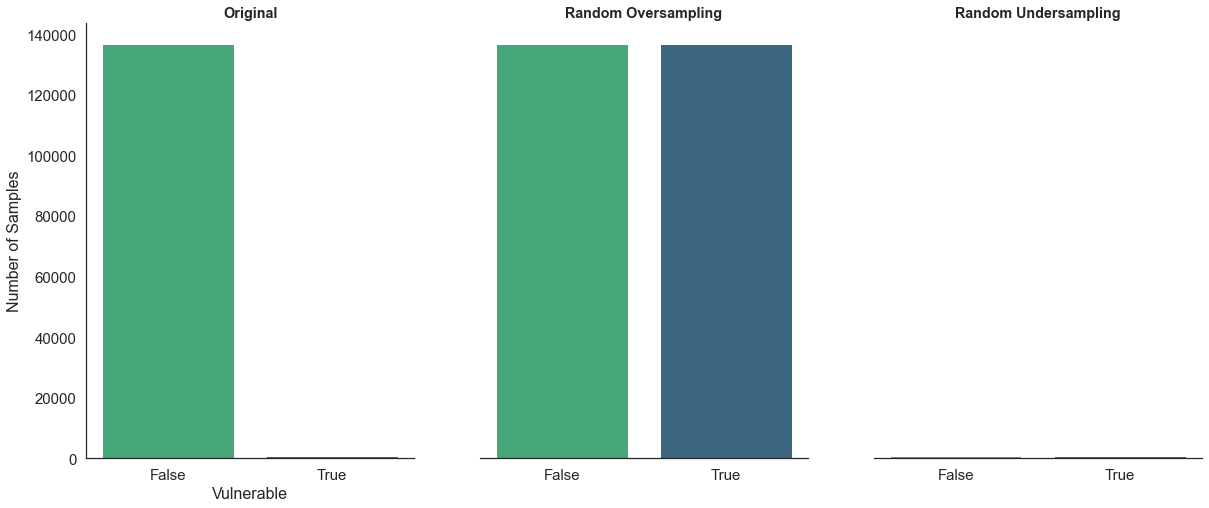

In [14]:
df = pd.DataFrame()

over = df_test_over.vulnerable.to_list()
under = df_test_under.vulnerable.to_list()
original = final.vulnerable.to_list()

palette = 'viridis_r'


fig, ax = plt.subplots(1, 3, figsize=(20, 8), sharex = True)
#ax.set(ylim=(0, 300000))
sns.set(font_scale = 1.2, style='white')
sns.despine()
g1 = sns.countplot(original, ax=ax[0], palette=palette)
g2 = sns.countplot(over, ax=ax[1], palette=palette)
g3 = sns.countplot(under, ax=ax[2], palette=palette)

g1.set_xlabel('Vulnerable', fontsize=20)
g1.set_ylabel('Number of Samples', fontsize=20)

g3.set(ylim=(0, 140000))
g1.tick_params(labelsize=15)
g2.tick_params(labelsize=15)
g3.tick_params(labelsize=15)
g2.set_ylabel('')
g3.set_ylabel('')
ax[1].spines["left"].set_visible(False)
ax[2].spines["left"].set_visible(False)

ax[1].axes.get_yaxis().set_visible(False)
ax[2].axes.get_yaxis().set_visible(False)

ax[0].set_title('Original', fontweight ="bold", fontsize=25)
ax[1].set_title('Random Oversampling', fontweight ="bold", fontsize=25)
ax[2].set_title('Random Undersampling', fontweight ="bold", fontsize=25)

fig.savefig("/Volumes/Research/VulnerabilityDatasets/Vulnerability_datasets/code/ghidra/cb_multios_class_imbalance_comparison2.png")

## Train test split for all tests

In [79]:
from sklearn.model_selection import train_test_split

original_train, original_test = train_test_split(final, test_size=0.2)
under_train, under_test = train_test_split(df_test_under, test_size=0.2)
over_train, over_test = train_test_split(df_test_over, test_size=0.2)

### Save train/test dfs to csv

In [81]:
original_train.to_csv(path+'/final_dfs_for_reference/cbmultios_original_train_25April2021.csv')
original_test.to_csv(path+'/final_dfs_for_reference/cbmultios_original_test_25April2021.csv')

In [82]:
under_train.to_csv(path+'/final_dfs_for_reference/cbmultios_under_train_25April2021.csv')
under_test.to_csv(path+'/final_dfs_for_reference/cbmultios_under_test_25April2021.csv')

In [83]:
over_train.to_csv(path+'/final_dfs_for_reference/cbmultios_over_train_25April2021.csv')
over_test.to_csv(path+'/final_dfs_for_reference/cbmultios_over_test_25April2021.csv')

### Save just `fuzzy_instr` column to .txt for processing

In [89]:
path

'/Volumes/Research/VulnerabilityDatasets/Vulnerability_datasets/code/ghidra/ghidra_extractions-main'

In [85]:
original_train['fuzzy_instr'].to_csv(path+'/final_dfs_for_reference/cbmultios_original_train_25April2021.txt', header=None, index=None, sep=' ', mode='a')
original_test['fuzzy_instr'].to_csv(path+'/final_dfs_for_reference/cbmultios_original_test_25April2021.txt', header=None, index=None, sep=' ', mode='a')

use `sed` to remove quotes from files

In [90]:
!sed -i "" 's/"//g' /Volumes/Research/VulnerabilityDatasets/Vulnerability_datasets/code/ghidra/ghidra_extractions-main/final_dfs_for_reference/cbmultios_original_train_25April2021.txt

In [91]:
!sed -i "" 's/"//g' /Volumes/Research/VulnerabilityDatasets/Vulnerability_datasets/code/ghidra/ghidra_extractions-main/final_dfs_for_reference/cbmultios_original_test_25April2021.txt

In [86]:
under_train['fuzzy_instr'].to_csv(path+'/final_dfs_for_reference/cbmultios_under_train_25April2021.txt', header=None, index=None, sep=' ', mode='a')
under_test['fuzzy_instr'].to_csv(path+'/final_dfs_for_reference/cbmultios_under_test_25April2021.txt', header=None, index=None, sep=' ', mode='a')

In [92]:
!sed -i "" 's/"//g' /Volumes/Research/VulnerabilityDatasets/Vulnerability_datasets/code/ghidra/ghidra_extractions-main/final_dfs_for_reference/cbmultios_under_train_25April2021.txt

In [93]:
!sed -i "" 's/"//g' /Volumes/Research/VulnerabilityDatasets/Vulnerability_datasets/code/ghidra/ghidra_extractions-main/final_dfs_for_reference/cbmultios_under_test_25April2021.txt

In [87]:
over_train['fuzzy_instr'].to_csv(path+'/final_dfs_for_reference/cbmultios_over_train_25April2021.txt', header=None, index=None, sep=' ', mode='a')
over_test['fuzzy_instr'].to_csv(path+'/final_dfs_for_reference/cbmultios_over_test_25April2021.txt', header=None, index=None, sep=' ', mode='a')

In [94]:
!sed -i "" 's/"//g' /Volumes/Research/VulnerabilityDatasets/Vulnerability_datasets/code/ghidra/ghidra_extractions-main/final_dfs_for_reference/cbmultios_over_train_25April2021.txt

In [95]:
!sed -i "" 's/"//g' /Volumes/Research/VulnerabilityDatasets/Vulnerability_datasets/code/ghidra/ghidra_extractions-main/final_dfs_for_reference/cbmultios_over_test_25April2021.txt

# D2V

In [6]:
def read_corpus(fname, tokens_only=False):
    with smart_open.open(fname, encoding="iso-8859-1") as f:
        for i, line in enumerate(f):
            tokens = gensim.utils.simple_preprocess(line)
            if tokens_only:
                yield tokens
            else:
                # For training data, add tags
                yield gensim.models.doc2vec.TaggedDocument(tokens, [i])

## Using Original Dataset

In [97]:
original_train_txt = path+'/final_dfs_for_reference/cbmultios_original_train_25April2021.txt'

In [98]:
original_test_txt = path+'/final_dfs_for_reference/cbmultios_original_test_25April2021.txt'

In [99]:
%%time
train_corpus = list(read_corpus(original_train_txt))

In [100]:
%%time
test_corpus = list(read_corpus(original_test_txt, tokens_only=True))

CPU times: user 5.8 s, sys: 199 ms, total: 6 s
Wall time: 6.1 s


In [102]:
len(train_corpus)

110184

In [103]:
len(test_corpus)

27546

### Create a D2V Model

In [104]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=100, min_count=2, epochs=40)

In [105]:
%%time
model.build_vocab(train_corpus)

CPU times: user 25.9 s, sys: 545 ms, total: 26.4 s
Wall time: 26.6 s


In [106]:
%%time
model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

CPU times: user 8min 16s, sys: 49.2 s, total: 9min 5s
Wall time: 5min 53s


#### save model to disk

In [107]:
model.save(path+'doc2vecModel_original_26April21')

### Test The Model

#### Use the test set set to test the model

In [108]:
milestones = [1000, 2000, 4000, 6000, 8000, 10000, 15000, 18000, 20000, 24000, 27546]

In [109]:
def get_data(test_corpus):
    comparison = list()
    start_time = time.time()
    for ind, doc_id in enumerate(test_corpus):
        
        # see if milestone reached
        if ind in milestones:
            print('milestone reached: ', ind)
            print(f'Time taken : {(time.time() - start_time) / 60:.2f} mins')
        
        # do for all test corpus and infer a vector from the model
        inferred_vector = model.infer_vector(test_corpus[ind])
        sims = model.docvecs.most_similar([inferred_vector], topn=2)

        # Compare and print the most/median/least similar documents from the train corpus
        actual = original_test.iloc[ind]['vulnerable']
        actual_fun_name = original_test.iloc[ind]['fun_name']
        actual_instr = original_test.iloc[ind]['fuzzy_instr']

        i = sims[0][0]
        predicted = original_train.iloc[i]['vulnerable']
        predicted_fun_name = original_train.iloc[i]['fun_name']
        predicted_instr = original_train.iloc[i]['fuzzy_instr']
        
        i = sims[1][0]
        predicted_2 = original_train.iloc[i]['vulnerable']
        predicted_fun_name_2 = original_train.iloc[i]['fun_name']
        predicted_instr_2 = original_train.iloc[i]['fuzzy_instr']
        
        comparison.append([actual_fun_name, 
                           actual, 
                           actual_instr, 
                           predicted_fun_name, 
                           predicted, 
                           predicted_instr, 
                           predicted_fun_name_2, 
                           predicted_2, 
                           predicted_instr_2])

    print(f'Time taken : {(time.time() - start_time) / 60:.2f} mins')
    return comparison

In [110]:
comparison = get_data(test_corpus)

milestone reached:  1000
Time taken : 0.13 mins
milestone reached:  2000
Time taken : 0.25 mins
milestone reached:  4000
Time taken : 0.67 mins
milestone reached:  6000
Time taken : 0.93 mins
milestone reached:  8000
Time taken : 1.18 mins
milestone reached:  10000
Time taken : 1.44 mins
milestone reached:  15000
Time taken : 2.04 mins
milestone reached:  18000
Time taken : 2.40 mins
milestone reached:  20000
Time taken : 2.64 mins
milestone reached:  24000
Time taken : 3.11 mins
Time taken : 3.54 mins


In [111]:
comparison_df = pd.DataFrame(comparison, columns=['fun_name', 'actual', 'fuzzy_instr_act', 'closest_fun', 'prediction', 'fuzzy_instr_pred', '2nd_closest_fun', '2nd_prediction', '2nd_fuzzy_instr_pred'])

In [112]:
comparison_df

,fun_name,actual,fuzzy_instr_act,closest_fun,prediction,fuzzy_instr_pred,2nd_closest_fun,2nd_prediction,2nd_fuzzy_instr_pred
0,__invoke,False,push ebx push edi push esi sub esp num mov esi...,__invoke,False,push ebx push edi push esi sub esp num mov esi...,__invoke,False,push ebx push edi push esi sub esp num mov esi...
1,cgc_memchr,False,push ebp mov ebp esp push esi sub esp num mov ...,cgc_memchr,False,push ebp mov ebp esp push esi sub esp num mov ...,cgc_memchr,False,push ebp mov ebp esp push esi sub esp num mov ...
2,__invoke,False,sub esp num mov eax esp num mov ecx esp num mo...,__invoke,False,sub esp num mov eax esp num mov ecx esp num mo...,__invoke,False,sub esp num mov eax esp num mov ecx esp num mo...
3,__i686.get_pc_thunk.bx,False,mov ebx esp ret,__x86.get_pc_thunk.bx,False,mov ebx esp ret,__i686.get_pc_thunk.bx,False,mov ebx esp ret
4,Token,False,mov eax esp num xor ecx ecx mov eax ecx mov ea...,Token,False,mov eax esp num xor ecx ecx mov eax ecx mov ea...,Token,False,mov eax esp num xor ecx ecx mov eax ecx mov ea...
...,...,...,...,...,...,...,...,...,...
27541,~ListCmd,False,push ebp mov ebp esp sub esp num mov eax ebp n...,DoubleListDeclare,False,push ebp mov ebp esp sub esp num mov eax ebp n...,~vector,False,push ebp mov ebp esp sub esp num mov eax ebp n...
27542,__invoke,False,push ebx push edi push esi sub esp num mov esi...,__invoke,False,push ebx push edi push esi sub esp num mov esi...,__invoke,False,push ebx push edi push esi sub esp num mov esi...
27543,_fini,False,endbr push ebx sub esp num call addr add ebx n...,_fini,False,endbr push ebx sub esp num call addr add ebx n...,_fini,False,endbr push ebx sub esp num call addr add ebx n...
27544,getLength,False,push ebp mov ebp esp and esp addr mov eax ebp ...,cgc_toupper,False,mov ecx esp num lea edx ecx num mov eax ecx an...,cgc_toupper,False,mov ecx esp num lea edx ecx num mov eax ecx an...


In [113]:
path

'/Volumes/Research/VulnerabilityDatasets/Vulnerability_datasets/code/ghidra/ghidra_extractions-main'

In [116]:
comparison_df.to_csv(path+'/d2v_original/cbmultios_d2v_original_all.csv')

### Metrics

In [117]:
def metrics(df_confusion):
    stats_list = list()

    fn = df_confusion[0][1]
    tp = df_confusion[1][1]
    tn = df_confusion[0][0]
    fp = df_confusion[1][0]
    accuracy = (tp+tn)/(tp+fp+fn+tn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    fpr = fp / (fp+tn)
    fnr = fn / (tp +fn)
    f1 = (2*precision*recall)/(precision+recall)
    stats_list.append([fn,tp,tn,fp,accuracy,precision,recall,fpr,fnr,f1])
    return stats_list

In [125]:
def get_results(df): 
    y_actu = pd.Series(df['actual'], name='Actual')
    y_pred = pd.Series(df['2nd_prediction'], name='Predicted')
    df_confusion = pd.crosstab(y_actu, y_pred)
    metrics(df_confusion)
    return df_confusion

In [119]:
def save_df(df, dir_name, model_info):
    directory = path + dir_name + '/'
    today = str(date.today())
    full = directory+model_info+'_'+today+'.csv'
    df.to_csv(full)

In [126]:
def save_stats(df):
    df_confusion = get_results(df)
    print(df_confusion)
    stats_list = metrics(df_confusion)
    stats_df = pd.DataFrame(stats_list, columns=['fn','tp','tn','fp','accuracy','precision','recall','fpr','fnr','f1'])
    save_df(stats_df, '/cbmultios_metrics', 'cbmultios_d2v_original_secondchoice_stats')
    return stats_df

In [124]:
first_prediction_df = save_stats(comparison_df)
first_prediction_df

Predicted  False  True 
Actual                 
False      27322     58
True         159      7


,fn,tp,tn,fp,accuracy,precision,recall,fpr,fnr,f1
0,159,7,27322,58,0.992122,0.107692,0.042169,0.002118,0.957831,0.060606


In [127]:
second_prediction_df = save_stats(comparison_df)
second_prediction_df

Predicted  False  True 
Actual                 
False      27315     65
True         156     10


,fn,tp,tn,fp,accuracy,precision,recall,fpr,fnr,f1
0,156,10,27315,65,0.991977,0.133333,0.060241,0.002374,0.939759,0.082988


## Using Random Undersampled Dataset

In [128]:
under_train_txt = path+'/final_dfs_for_reference/cbmultios_under_train_25April2021.txt'

In [129]:
under_test_txt = path+'/final_dfs_for_reference/cbmultios_under_test_25April2021.txt'

In [130]:
%%time
train_corpus = list(read_corpus(under_train_txt))

CPU times: user 2.71 s, sys: 491 ms, total: 3.21 s
Wall time: 3.49 s


In [131]:
%%time
test_corpus = list(read_corpus(under_test_txt, tokens_only=True))

CPU times: user 685 ms, sys: 156 ms, total: 841 ms
Wall time: 968 ms


In [132]:
len(train_corpus)

1420

In [133]:
len(test_corpus)

356

### Create a D2V Model

In [134]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=100, min_count=2, epochs=40)

In [135]:
%%time
model.build_vocab(train_corpus)

CPU times: user 580 ms, sys: 9.79 ms, total: 590 ms
Wall time: 592 ms


In [136]:
%%time
model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

CPU times: user 30.9 s, sys: 1.09 s, total: 32 s
Wall time: 17.2 s


#### save model to disk

In [137]:
model.save(path+'doc2vecModel_under_26April21')

### Test The Model

#### Use the test set set to test the model

In [141]:
milestones = [.1*len(test_corpus), .2*len(test_corpus), .3*len(test_corpus), .4*len(test_corpus), .5*len(test_corpus), .6*len(test_corpus), .7*len(test_corpus), 
             .8*len(test_corpus), .9*len(test_corpus), 1*len(test_corpus)]
milestones = [round(x) for x in milestones]
milestones

[36, 71, 107, 142, 178, 214, 249, 285, 320, 356]

In [142]:
def get_data(test_corpus):
    comparison = list()
    start_time = time.time()
    for ind, doc_id in enumerate(test_corpus):
        
        # see if milestone reached
        if ind in milestones:
            print('milestone reached: ', ind)
            print(f'Time taken : {(time.time() - start_time) / 60:.2f} mins')
        
        # do for all test corpus and infer a vector from the model
        inferred_vector = model.infer_vector(test_corpus[ind])
        sims = model.docvecs.most_similar([inferred_vector], topn=2)

        # Compare and print the most/median/least similar documents from the train corpus
        actual = under_test.iloc[ind]['vulnerable']
        actual_fun_name = under_test.iloc[ind]['fun_name']
        actual_instr = under_test.iloc[ind]['fuzzy_instr']

        i = sims[0][0]
        predicted = under_train.iloc[i]['vulnerable']
        predicted_fun_name = under_train.iloc[i]['fun_name']
        predicted_instr = under_train.iloc[i]['fuzzy_instr']
        
        i = sims[1][0]
        predicted_2 = under_train.iloc[i]['vulnerable']
        predicted_fun_name_2 = under_train.iloc[i]['fun_name']
        predicted_instr_2 = under_train.iloc[i]['fuzzy_instr']
        
        comparison.append([actual_fun_name, 
                           actual, 
                           actual_instr, 
                           predicted_fun_name, 
                           predicted, 
                           predicted_instr, 
                           predicted_fun_name_2, 
                           predicted_2, 
                           predicted_instr_2])

    print(f'Time taken : {(time.time() - start_time) / 60:.2f} mins')
    return comparison

In [143]:
comparison = get_data(test_corpus)

milestone reached:  36
Time taken : 0.01 mins
milestone reached:  71
Time taken : 0.02 mins
milestone reached:  107
Time taken : 0.04 mins
milestone reached:  142
Time taken : 0.05 mins
milestone reached:  178
Time taken : 0.06 mins
milestone reached:  214
Time taken : 0.07 mins
milestone reached:  249
Time taken : 0.08 mins
milestone reached:  285
Time taken : 0.09 mins
milestone reached:  320
Time taken : 0.11 mins
Time taken : 0.12 mins


In [144]:
comparison_df = pd.DataFrame(comparison, columns=['fun_name', 'actual', 'fuzzy_instr_act', 'closest_fun', 'prediction', 'fuzzy_instr_pred', '2nd_closest_fun', '2nd_prediction', '2nd_fuzzy_instr_pred'])

In [145]:
comparison_df

,fun_name,actual,fuzzy_instr_act,closest_fun,prediction,fuzzy_instr_pred,2nd_closest_fun,2nd_prediction,2nd_fuzzy_instr_pred
0,__invoke,False,push ebx push edi push esi sub esp num mov ebx...,__invoke,False,push ebx push edi push esi sub esp num mov ebx...,__invoke,False,push ebx push edi push esi sub esp num mov ebx...
1,FUN_0804a030,False,push addr jmp addr,DoubleLink,False,push ebp mov ebp esp mov eax ebp num mov ecx e...,cgc_alloc_txn_head,False,push ebp mov ebp esp sub esp num mov esp num c...
2,cgc_isupper,False,push ebp mov ebp esp push eax mov eax ebp num ...,cgc_isalpha,False,push ebp mov ebp esp push eax mov eax ebp num ...,cgc_isprint,False,push ebp mov ebp esp push eax mov eax ebp num ...
3,Name,True,push ebp mov ebp esp push esi sub esp num mov ...,ListFileNext,False,push ebp mov ebp esp push esi sub esp num mov ...,cgc_list_remove_node,False,push ebp mov ebp esp push esi sub esp num mov ...
4,cgc_addAirport,True,push ebp mov ebp esp push esi sub esp num mov ...,cgc_rmdir,False,push ebp mov ebp esp sub esp num mov eax ebp n...,cgc_merge_employee_records,True,push ebp mov ebp esp push edi push esi sub esp...
...,...,...,...,...,...,...,...,...,...
351,__invoke,False,push edi push esi sub esp num mov eax esp num ...,__invoke,False,push edi push esi sub esp num mov eax esp num ...,__invoke,False,push edi push esi sub esp num mov eax esp num ...
352,cgc_strncasecmp,False,push ebp mov ebp esp push edi push esi sub esp...,cgc_L2_RxFrame,True,push ebp mov ebp esp push edi push esi sub esp...,cgc_L2_RxFrame,True,push ebp mov ebp esp push edi push esi sub esp...
353,cgc_process_hypernutritionmarae,True,push ebp mov ebp esp push esi sub esp num mov ...,cgc_process_Slovenerecure,True,push ebp mov ebp esp push esi sub esp num mov ...,cgc_process_nowhitoffscape,True,push ebp mov ebp esp push esi sub esp num mov ...
354,runMetadata,True,push ebp push ebx push edi push esi sub esp nu...,cgc_tolower,False,push ebp mov ebp esp sub esp num mov eax ebp n...,put,False,push ebp mov ebp esp sub esp num mov al ebp nu...


In [146]:
path

'/Volumes/Research/VulnerabilityDatasets/Vulnerability_datasets/code/ghidra/ghidra_extractions-main'

In [147]:
comparison_df.to_csv(path+'/d2v_cbmultios_finaltest_df/cbmultios_d2v_under_all.csv')

### Metrics

In [148]:
def metrics(df_confusion):
    stats_list = list()

    fn = df_confusion[0][1]
    tp = df_confusion[1][1]
    tn = df_confusion[0][0]
    fp = df_confusion[1][0]
    accuracy = (tp+tn)/(tp+fp+fn+tn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    fpr = fp / (fp+tn)
    fnr = fn / (tp +fn)
    f1 = (2*precision*recall)/(precision+recall)
    stats_list.append([fn,tp,tn,fp,accuracy,precision,recall,fpr,fnr,f1])
    return stats_list

In [154]:
def get_results(df): 
    y_actu = pd.Series(df['actual'], name='Actual')
    y_pred = pd.Series(df['2nd_prediction'], name='Predicted')
    df_confusion = pd.crosstab(y_actu, y_pred)
    metrics(df_confusion)
    return df_confusion

In [150]:
def save_df(df, dir_name, model_info):
    directory = path + dir_name + '/'
    today = str(date.today())
    full = directory+model_info+'_'+today+'.csv'
    df.to_csv(full)

In [153]:
def save_stats(df):
    df_confusion = get_results(df)
    print(df_confusion)
    stats_list = metrics(df_confusion)
    stats_df = pd.DataFrame(stats_list, columns=['fn','tp','tn','fp','accuracy','precision','recall','fpr','fnr','f1'])
    save_df(stats_df, '/cbmultios_metrics', 'cbmultios_d2v_under_secondchoice_stats')
    return stats_df

In [152]:
first_prediction_df = save_stats(comparison_df)
first_prediction_df

Predicted  False  True 
Actual                 
False        145     23
True          41    147


,fn,tp,tn,fp,accuracy,precision,recall,fpr,fnr,f1
0,41,147,145,23,0.820225,0.864706,0.781915,0.136905,0.218085,0.821229


In [155]:
second_prediction_df = save_stats(comparison_df)
second_prediction_df

Predicted  False  True 
Actual                 
False        138     30
True          49    139


,fn,tp,tn,fp,accuracy,precision,recall,fpr,fnr,f1
0,49,139,138,30,0.77809,0.822485,0.739362,0.178571,0.260638,0.778711


## Using Random Oversampled Dataset

In [3]:
over_train_txt = path+'/final_dfs_for_reference/cbmultios_over_train_25April2021.txt'

In [4]:
over_test_txt = path+'/final_dfs_for_reference/cbmultios_over_test_25April2021.txt'

In [7]:
%%time
train_corpus = list(read_corpus(over_train_txt))

CPU times: user 5min 44s, sys: 1min 22s, total: 7min 7s
Wall time: 7min 17s


In [8]:
%%time
test_corpus = list(read_corpus(over_test_txt, tokens_only=True))

CPU times: user 1min 22s, sys: 2.64 s, total: 1min 25s
Wall time: 1min 26s


In [9]:
len(train_corpus)

218947

In [10]:
len(test_corpus)

54737

### Create a D2V Model

In [11]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=100, min_count=2, epochs=40)

In [12]:
%%time
model.build_vocab(train_corpus)

CPU times: user 1min 28s, sys: 21.1 s, total: 1min 49s
Wall time: 2min 7s


In [13]:
%%time
model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

CPU times: user 1h 23min 30s, sys: 19min 33s, total: 1h 43min 3s
Wall time: 1h 5min 52s


#### save model to disk

In [14]:
model.save(path+'doc2vecModel_over_26April21')

### Test The Model

In [19]:
over_train = pd.read_csv(path+'/final_dfs_for_reference/cbmultios_over_train_25April2021.csv', index_col=[0])

In [20]:
over_test = pd.read_csv(path+'/final_dfs_for_reference/cbmultios_over_test_25April2021.csv', index_col=[0])

In [28]:
over_train = over_train.reset_index(drop=True)

In [26]:
over_test = over_test.reset_index(drop=True)

#### Use the test set set to test the model

In [15]:
milestones = [.1*len(test_corpus), .2*len(test_corpus), .3*len(test_corpus), .4*len(test_corpus), .5*len(test_corpus), .6*len(test_corpus), .7*len(test_corpus), 
             .8*len(test_corpus), .9*len(test_corpus), 1*len(test_corpus)]
milestones = [round(x) for x in milestones]
milestones

[5474, 10947, 16421, 21895, 27368, 32842, 38316, 43790, 49263, 54737]

In [29]:
def get_data(test_corpus):
    comparison = list()
    start_time = time.time()
    for ind, doc_id in enumerate(test_corpus):
        
        # see if milestone reached
        if ind in milestones:
            print('milestone reached: ', ind)
            print(f'Time taken : {(time.time() - start_time) / 60:.2f} mins')
        
        # do for all test corpus and infer a vector from the model
        inferred_vector = model.infer_vector(test_corpus[ind])
        sims = model.docvecs.most_similar([inferred_vector], topn=2)

        # Compare and print the most/median/least similar documents from the train corpus
        actual = over_test.iloc[ind]['vulnerable']
        actual_fun_name = over_test.iloc[ind]['fun_name']
        actual_instr = over_test.iloc[ind]['fuzzy_instr']

        i = sims[0][0]
        predicted = over_train.iloc[i]['vulnerable']
        predicted_fun_name = over_train.iloc[i]['fun_name']
        predicted_instr = over_train.iloc[i]['fuzzy_instr']
        
        i = sims[1][0]
        predicted_2 = over_train.iloc[i]['vulnerable']
        predicted_fun_name_2 = over_train.iloc[i]['fun_name']
        predicted_instr_2 = over_train.iloc[i]['fuzzy_instr']
        
        comparison.append([actual_fun_name, 
                           actual, 
                           actual_instr, 
                           predicted_fun_name, 
                           predicted, 
                           predicted_instr, 
                           predicted_fun_name_2, 
                           predicted_2, 
                           predicted_instr_2])

    print(f'Time taken : {(time.time() - start_time) / 60:.2f} mins')
    return comparison

In [30]:
comparison = get_data(test_corpus)

milestone reached:  5474
Time taken : 2.08 mins
milestone reached:  10947
Time taken : 4.13 mins
milestone reached:  16421
Time taken : 6.22 mins
milestone reached:  21895
Time taken : 8.32 mins
milestone reached:  27368
Time taken : 10.43 mins
milestone reached:  32842
Time taken : 12.54 mins
milestone reached:  38316
Time taken : 19.71 mins
milestone reached:  43790
Time taken : 21.78 mins
milestone reached:  49263
Time taken : 23.87 mins
Time taken : 26.01 mins


In [31]:
comparison_df = pd.DataFrame(comparison, columns=['fun_name', 'actual', 'fuzzy_instr_act', 'closest_fun', 'prediction', 'fuzzy_instr_pred', '2nd_closest_fun', '2nd_prediction', '2nd_fuzzy_instr_pred'])

In [32]:
comparison_df

,fun_name,actual,fuzzy_instr_act,closest_fun,prediction,fuzzy_instr_pred,2nd_closest_fun,2nd_prediction,2nd_fuzzy_instr_pred
0,cgc_seed_prng_array,False,push ebp mov ebp esp sub esp num mov eax ebp n...,__invoke,False,push edi push esi sub esp num mov eax esp num ...,cgc_seed_prng_array,False,push ebp mov ebp esp sub esp num mov eax ebp n...
1,cgc_process_monodromiclyretail,True,push ebp mov ebp esp push esi sub esp num mov ...,cgc_process_crouchingpurebred,True,push ebp mov ebp esp push esi sub esp num mov ...,cgc_process_hanginglypoethood,True,push ebp mov ebp esp push esi sub esp num mov ...
2,cgc_insert_stock,True,push ebp mov ebp esp push esi sub esp num mov ...,"operator""""_T",False,push esi mov eax esp num mov ecx esp num mov e...,Recv,False,push edi push esi sub esp num mov edi esp num ...
3,push_back,False,push ebp mov ebp esp push edi push esi sub esp...,cgc_memmove,False,push ebp mov ebp esp push esi sub esp num mov ...,length,False,push ebp mov ebp esp push eax mov eax ebp num ...
4,cgc_remove,True,push ebp mov ebp esp mov eax ebp num mov ecx e...,__invoke,False,mov eax esp num mov eax num mov eax num num mo...,__invoke,False,mov eax esp num mov eax num mov eax num num mo...
...,...,...,...,...,...,...,...,...,...
54732,cgc_memmove,False,push ebp mov ebp esp push esi sub esp num mov ...,cgc_memmove,False,push ebp mov ebp esp push esi sub esp num mov ...,cgc_memmove,False,push ebp mov ebp esp push esi sub esp num mov ...
54733,cgc_hash_seed,False,push ebp mov ebp esp sub esp num mov eax ebp n...,register_tm_clones,False,mov eax addr sub eax addr mov edx eax shr eax ...,cgc_strlen,False,push ebp mov ebp esp push eax mov eax ebp num ...
54734,cgc_delete_message,True,push ebp mov ebp esp sub esp num mov eax ebp n...,readnum,True,push ebp mov ebp esp sub esp num mov eax ebp n...,cgc_strlen,False,push ebp mov ebp esp sub esp num mov eax ebp n...
54735,Usage,False,push ebp mov ebp esp push eax mov eax ebp num ...,GetType,False,push ebp mov ebp esp push eax mov eax ebp num ...,GetType,False,push ebp mov ebp esp push eax mov eax ebp num ...


In [ ]:
path

In [33]:
comparison_df.to_csv(path+'/d2v_cbmultios_finaltest_df/cbmultios_d2v_over_all.csv')

### Metrics

In [34]:
def metrics(df_confusion):
    stats_list = list()

    fn = df_confusion[0][1]
    tp = df_confusion[1][1]
    tn = df_confusion[0][0]
    fp = df_confusion[1][0]
    accuracy = (tp+tn)/(tp+fp+fn+tn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    fpr = fp / (fp+tn)
    fnr = fn / (tp +fn)
    f1 = (2*precision*recall)/(precision+recall)
    stats_list.append([fn,tp,tn,fp,accuracy,precision,recall,fpr,fnr,f1])
    return stats_list

In [55]:
def get_results(df): 
    y_actu = pd.Series(df['actual'], name='Actual')
    y_pred = pd.Series(df['2nd_prediction'], name='Predicted')
    df_confusion = pd.crosstab(y_actu, y_pred)
    metrics(df_confusion)
    return df_confusion

In [36]:
def save_df(df, dir_name, model_info):
    directory = path + dir_name + '/'
    today = str(date.today())
    full = directory+model_info+'_'+today+'.csv'
    df.to_csv(full)

In [54]:
def save_stats(df):
    df_confusion = get_results(df)
    print(df_confusion)
    stats_list = metrics(df_confusion)
    stats_df = pd.DataFrame(stats_list, columns=['fn','tp','tn','fp','accuracy','precision','recall','fpr','fnr','f1'])
    save_df(stats_df, '/cbmultios_metrics', 'cbmultios_d2v_over_secondchoice_stats')
    return stats_df

In [53]:
first_prediction_df = save_stats(comparison_df)
first_prediction_df

Predicted  False  True 
Actual                 
False      23935   3581
True        9163  18058


,fn,tp,tn,fp,accuracy,precision,recall,fpr,fnr,f1
0,9163,18058,23935,3581,0.767178,0.834512,0.663385,0.130142,0.336615,0.739173


In [56]:
second_prediction_df = save_stats(comparison_df)
second_prediction_df

Predicted  False  True 
Actual                 
False      23644   3872
True        8577  18644


,fn,tp,tn,fp,accuracy,precision,recall,fpr,fnr,f1
0,8577,18644,23644,3872,0.772567,0.828033,0.684912,0.140718,0.315088,0.749703


# FastText

## Using Original Dataset

In [15]:
original_train = pd.read_csv(path+'/final_dfs_for_reference/cbmultios_original_train_25April2021.csv', index_col=[0])

In [16]:
original_test = pd.read_csv(path+'/final_dfs_for_reference/cbmultios_original_test_25April2021.csv', index_col=[0])

In [22]:
original_train = original_train.reset_index(drop=True)
original_test = original_test.reset_index(drop=True)

In [17]:
train_df = original_train[['fun_name', 'vulnerable', 'fuzzy_instr']]

In [18]:
train_df['label'] = list(range(len(train_df.index)))

<ipython-input-18-f64bb0f5bc56>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['label'] = list(range(len(train_df.index)))


In [19]:
train_df['label'] = train_df.label.apply(lambda x: '__label__' + str(x))

<ipython-input-19-737cbc42e4ea>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['label'] = train_df.label.apply(lambda x: '__label__' + str(x))


In [143]:
train_df[['label','fuzzy_instr']].to_csv(path+ '/fasttext/fasttext_cbmultios_original_train2_26April21.txt', header=None, index=None, sep=' ', mode='a')

In [117]:
path

'/Volumes/Research/VulnerabilityDatasets/Vulnerability_datasets/code/ghidra/ghidra_extractions-main'

find and replace all " " from the train and test files

In [118]:
!sed -i "" 's/"//g' /Volumes/Research/VulnerabilityDatasets/Vulnerability_datasets/code/ghidra/ghidra_extractions-main/fasttext/fasttext_cbmultios_original_train_26April21.txt

In [144]:
!sed -i "" 's/"//g' /Volumes/Research/VulnerabilityDatasets/Vulnerability_datasets/code/ghidra/ghidra_extractions-main/fasttext/fasttext_cbmultios_original_train2_26April21.txt

### train the supervised model

In [146]:
%%time
#run1
model = fasttext.train_supervised(input=path+'/fasttext/fasttext_cbmultios_original_train2_26April21.txt')

CPU times: user 3h 26min 11s, sys: 42 s, total: 3h 26min 53s
Wall time: 30min 57s


In [4]:
%%time
#run2
model2 = fasttext.train_supervised(input=path+'/fasttext/fasttext_cbmultios_original_train2_26April21.txt',  lr=.3, epoch=25, wordNgrams=2)

CPU times: user 18h 42min 22s, sys: 5min 41s, total: 18h 48min 4s
Wall time: 3h 3min 56s


### save the model

In [147]:
model.save_model(path+'/fasttext/fasttext_cbmultios_original_train2_26April21.bin')

In [5]:
model2.save_model(path+'/fasttext/fasttext_cbmultios_original_train3_26April21.bin')

### use test set to assess the model

In [23]:
original_test.head()

,sample_name,fun_name,fun_instr,vulnerable,fuzzy_instr
0,Azurad,__invoke,"['PUSH EBX', 'PUSH EDI', 'PUSH ESI', 'SUB ESP,...",False,push ebx push edi push esi sub esp num mov esi...
1,Printer_patched,cgc_memchr,"['PUSH EBP', 'MOV EBP,ESP', 'PUSH ESI', 'SUB E...",False,push ebp mov ebp esp push esi sub esp num mov ...
2,FailAV_patched,__invoke,"['SUB ESP,0xc', 'MOV EAX,dword ptr [ESP + 0x10...",False,sub esp num mov eax esp num mov ecx esp num mo...
3,Checkmate,__i686.get_pc_thunk.bx,"['MOV EBX,dword ptr [ESP]', 'RET']",False,mov ebx esp ret
4,Azurad,Token,"['MOV EAX,dword ptr [ESP + 0x4]', 'XOR ECX,ECX...",False,mov eax esp num xor ecx ecx mov eax ecx mov ea...


In [123]:
original_test[['fuzzy_instr']].to_csv(path+ '/fasttext/fasttext_cbmultios_original_test_26April21.txt', header=None, index=None, sep=' ', mode='a')

In [124]:
path

'/Volumes/Research/VulnerabilityDatasets/Vulnerability_datasets/code/ghidra/ghidra_extractions-main'

In [125]:
!sed -i "" 's/"//g' /Volumes/Research/VulnerabilityDatasets/Vulnerability_datasets/code/ghidra/ghidra_extractions-main/fasttext/fasttext_cbmultios_original_test_26April21.txt

In [126]:
model.predict('push sbp mov rbp rsp sub num mov rbp addr mov rsi rbp addr lea num mov num call addr add num pop sbp ret')

(('__label__copy',), array([0.06839915]))

In [25]:
def get_results(test_set):
    results = list()
    start_time = time.time()

    for i, test in enumerate(test_set): 

        # see if milestone reached
        if i in milestones:
            print('milestone reached: ', i)
            print(f'Time taken : {(time.time() - start_time) / 60:.2f} mins')
            
        test_str = str(test)
        result = list(model2.predict(test))
        #print(result)
        
        '''
        predicted_fun_name = list(result[0])[0].replace("__label__",'')
        train_index = original_train.index[original_train['fun_name'] == predicted_fun_name].tolist()[0]
        predicted = original_train.iloc[train_index]['vulnerable']
        predicted_instr = original_train.iloc[train_index]['fuzzy_instr']'''
        
        predicted_label_name = list(result[0])[0]
        train_index = train_df.index[train_df['label'] == predicted_label_name].tolist()[0]
        predicted_fun_name = train_df.iloc[train_index]['fun_name']
        predicted = train_df.iloc[train_index]['vulnerable']
        predicted_instr = train_df.iloc[train_index]['fuzzy_instr']

        sim_array = result[1]
        actual = original_test.iloc[i]['vulnerable']
        actual_fun_name = original_test.iloc[i]['fun_name']
        actual_instr = original_test.iloc[i]['fuzzy_instr']

        results.append([actual_fun_name, actual, actual_instr, predicted_fun_name, predicted, predicted_instr])
        
    print(f'Time taken : {(time.time() - start_time) / 60:.2f} mins')
    return results

In [10]:
def read_corpus(fname):
    test_set = list()
    with smart_open.open(fname, encoding="UTF-8") as f:
        for i, line in enumerate(f):
            test_set.append(line.strip('\n'))
    return test_set

In [8]:
test = '/Volumes/Research/VulnerabilityDatasets/Vulnerability_datasets/code/ghidra/ghidra_extractions-main/fasttext/fasttext_cbmultios_original_test_26April21.txt'

In [11]:
test_corpus = list(read_corpus(test))

In [12]:
len(test_corpus)

27546

In [13]:
milestones = [.1*len(test_corpus), .2*len(test_corpus), .3*len(test_corpus), .4*len(test_corpus), .5*len(test_corpus), .6*len(test_corpus), .7*len(test_corpus), 
             .8*len(test_corpus), .9*len(test_corpus), 1*len(test_corpus)]
milestones = [round(x) for x in milestones]
milestones

[2755, 5509, 8264, 11018, 13773, 16528, 19282, 22037, 24791, 27546]

In [20]:
train_df = train_df.reset_index(drop=True)

In [26]:
results_model2 = get_results(test_corpus)

milestone reached:  2755
Time taken : 0.76 mins
milestone reached:  5509
Time taken : 1.52 mins
milestone reached:  8264
Time taken : 2.29 mins
milestone reached:  11018
Time taken : 3.03 mins
milestone reached:  13773
Time taken : 3.78 mins
milestone reached:  16528
Time taken : 4.52 mins
milestone reached:  19282
Time taken : 5.27 mins
milestone reached:  22037
Time taken : 6.02 mins
milestone reached:  24791
Time taken : 6.77 mins
Time taken : 7.52 mins


In [200]:
results_df = pd.DataFrame(results, columns=['actual_fun_name', 'actual', 'actual_instr', 'predicted_fun_name',  'predicted', 'predicted_instr'])
results_df

,actual_fun_name,actual,actual_instr,predicted_fun_name,predicted,predicted_instr
0,__invoke,False,push ebx push edi push esi sub esp num mov esi...,cgc_reset_baseband_state,False,push ebp mov ebp esp mov eax ebp num mov ecx e...
1,cgc_memchr,False,push ebp mov ebp esp push esi sub esp num mov ...,cgc_reset_baseband_state,False,push ebp mov ebp esp mov eax ebp num mov ecx e...
2,__invoke,False,sub esp num mov eax esp num mov ecx esp num mo...,cgc_reset_baseband_state,False,push ebp mov ebp esp mov eax ebp num mov ecx e...
3,__i686.get_pc_thunk.bx,False,mov ebx esp ret,cgc_receive,False,jmp addr
4,Token,False,mov eax esp num xor ecx ecx mov eax ecx mov ea...,cgc_reset_baseband_state,False,push ebp mov ebp esp mov eax ebp num mov ecx e...
...,...,...,...,...,...,...
27541,~ListCmd,False,push ebp mov ebp esp sub esp num mov eax ebp n...,cgc_reset_baseband_state,False,push ebp mov ebp esp mov eax ebp num mov ecx e...
27542,__invoke,False,push ebx push edi push esi sub esp num mov esi...,cgc_reset_baseband_state,False,push ebp mov ebp esp mov eax ebp num mov ecx e...
27543,_fini,False,endbr push ebx sub esp num call addr add ebx n...,cgc_gb_reset,False,mov eax esp num mov eax num addr mov eax num a...
27544,getLength,False,push ebp mov ebp esp and esp addr mov eax ebp ...,cgc_reset_baseband_state,False,push ebp mov ebp esp mov eax ebp num mov ecx e...


In [27]:
results_df_2 = pd.DataFrame(results_model2, columns=['actual_fun_name', 'actual', 'actual_instr', 'predicted_fun_name',  'predicted', 'predicted_instr'])
results_df_2

,actual_fun_name,actual,actual_instr,predicted_fun_name,predicted,predicted_instr
0,__invoke,False,push ebx push edi push esi sub esp num mov esi...,__invoke,False,push ebx push edi push esi sub esp num mov esi...
1,cgc_memchr,False,push ebp mov ebp esp push esi sub esp num mov ...,cgc_memchr,False,push ebp mov ebp esp push esi sub esp num mov ...
2,__invoke,False,sub esp num mov eax esp num mov ecx esp num mo...,__invoke,False,sub esp num mov eax esp num mov ecx esp num mo...
3,__i686.get_pc_thunk.bx,False,mov ebx esp ret,__i686.get_pc_thunk.bx,False,mov ebx esp ret
4,Token,False,mov eax esp num xor ecx ecx mov eax ecx mov ea...,Token,False,mov eax esp num xor ecx ecx mov eax ecx mov ea...
...,...,...,...,...,...,...
27541,~ListCmd,False,push ebp mov ebp esp sub esp num mov eax ebp n...,~CreateDirCmd,False,push ebp mov ebp esp sub esp num mov eax ebp n...
27542,__invoke,False,push ebx push edi push esi sub esp num mov esi...,__invoke,False,push ebx push edi push esi sub esp num mov esi...
27543,_fini,False,endbr push ebx sub esp num call addr add ebx n...,_fini,False,endbr push ebx sub esp num call addr add ebx n...
27544,getLength,False,push ebp mov ebp esp and esp addr mov eax ebp ...,getLength,False,push ebp mov ebp esp and esp addr mov eax ebp ...


In [ ]:
results_df_2.to_csv(path+'fasttext/results2_lr.3_epoch25_wordNgrams2.csv')

In [28]:
results_df_2.actual.value_counts()

False    27380
True       166
Name: actual, dtype: int64

In [29]:
results_df_2.predicted.value_counts()

False    27321
True       225
Name: predicted, dtype: int64

In [183]:
results_df.actual.value_counts()

False    27380
True       166
Name: actual, dtype: int64

In [184]:
results_df.predicted.value_counts()

False    27546
Name: predicted, dtype: int64

### Metrics

In [35]:
def metrics(df_confusion):
    stats_list = list()

    fn = df_confusion[0][1]
    try: 
        tp = df_confusion[1][1]
    except: 
        tp = 1
    tn = df_confusion[0][0]
    try: 
        fp = df_confusion[1][0]
    except: 
        fp = 1
    accuracy = (tp+tn)/(tp+fp+fn+tn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    fpr = fp / (fp+tn)
    fnr = fn / (tp +fn)
    f1 = (2*precision*recall)/(precision+recall)
    stats_list.append([fn,tp,tn,fp,accuracy,precision,recall,fpr,fnr,f1])
    return stats_list

In [36]:
def get_results(df): 
    y_actu = pd.Series(df['actual'], name='Actual')
    y_pred = pd.Series(df['predicted'], name='Predicted')
    df_confusion = pd.crosstab(y_actu, y_pred)
    metrics(df_confusion)
    return df_confusion

In [37]:
def save_df(df, dir_name, model_info):
    directory = path + dir_name + '/'
    today = str(date.today())
    full = directory+model_info+'_'+today+'.csv'
    df.to_csv(full)

In [38]:
def save_stats(df):
    df_confusion = get_results(df)
    print(df_confusion)
    stats_list = metrics(df_confusion)
    stats_df = pd.DataFrame(stats_list, columns=['fn','tp','tn','fp','accuracy','precision','recall','fpr','fnr','f1'])
    save_df(stats_df, '/cbmultios_metrics', 'cbmultios_fasttext_original_run2_stats')
    return stats_df

In [201]:
results = save_stats(results_df)
results

Predicted  False
Actual          
False      27380
True         166


,fn,tp,tn,fp,accuracy,precision,recall,fpr,fnr,f1
0,166,1,27380,1,0.993938,0.5,0.005988,0.000037,0.994012,0.011834


In [39]:
results2 = save_stats(results_df_2)
results2

Predicted  False  True 
Actual                 
False      27198    182
True         123     43


,fn,tp,tn,fp,accuracy,precision,recall,fpr,fnr,f1
0,123,43,27198,182,0.988928,0.191111,0.259036,0.006647,0.740964,0.219949


## Using Random Undersampled Dataset

In [ ]:
under_train.to_csv(path+'/final_dfs_for_reference/cbmultios_under_train_25April2021.csv')
under_test.to_csv(path+'/final_dfs_for_reference/cbmultios_under_test_25April2021.csv')

In [41]:
under_train = pd.read_csv(path+'/final_dfs_for_reference/cbmultios_under_train_25April2021.csv', index_col=[0])

In [42]:
under_test = pd.read_csv(path+'/final_dfs_for_reference/cbmultios_under_test_25April2021.csv', index_col=[0])

In [43]:
under_train = under_train.reset_index(drop=True)
under_test = under_test.reset_index(drop=True)

In [99]:
under_test.shape

(356, 5)

In [100]:
under_train.shape

(1420, 5)

In [44]:
train_df = under_train[['fun_name', 'vulnerable', 'fuzzy_instr']]

In [45]:
train_df['label'] = list(range(len(train_df.index)))

<ipython-input-45-f64bb0f5bc56>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['label'] = list(range(len(train_df.index)))


In [46]:
train_df['label'] = train_df.label.apply(lambda x: '__label__' + str(x))

<ipython-input-46-737cbc42e4ea>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['label'] = train_df.label.apply(lambda x: '__label__' + str(x))


In [47]:
train_df[['label','fuzzy_instr']].to_csv(path+ '/fasttext/fasttext_cbmultios_under_train_27April21.txt', header=None, index=None, sep=' ', mode='a')

In [48]:
path

'/Volumes/Research/VulnerabilityDatasets/Vulnerability_datasets/code/ghidra/ghidra_extractions-main'

find and replace all " " from the train and test files

In [49]:
!sed -i "" 's/"//g' /Volumes/Research/VulnerabilityDatasets/Vulnerability_datasets/code/ghidra/ghidra_extractions-main/fasttext/fasttext_cbmultios_under_train_27April21.txt

### train the supervised model

In [50]:
%%time
model = fasttext.train_supervised(input=path+'/fasttext/fasttext_cbmultios_under_train_27April21.txt',  lr=.3, epoch=25, wordNgrams=2)

CPU times: user 23.3 s, sys: 367 ms, total: 23.7 s
Wall time: 3.88 s


### save the model

In [51]:
model.save_model(path+'/fasttext/fasttext_cbmultios_under_train_27April21.bin')

### use test set to assess the model

In [ ]:
under_test.head()

In [54]:
under_test[['fuzzy_instr']].to_csv(path+ '/fasttext/fasttext_cbmultios_under_test_27April21.txt', header=None, index=None, sep=' ', mode='a')

In [55]:
path

'/Volumes/Research/VulnerabilityDatasets/Vulnerability_datasets/code/ghidra/ghidra_extractions-main'

In [57]:
!sed -i "" 's/"//g' /Volumes/Research/VulnerabilityDatasets/Vulnerability_datasets/code/ghidra/ghidra_extractions-main/fasttext/fasttext_cbmultios_under_test_27April21.txt

In [58]:
model.predict('push sbp mov rbp rsp sub num mov rbp addr mov rsi rbp addr lea num mov num call addr add num pop sbp ret')

(('__label__343',), array([0.00076869]))

In [64]:
def get_results(test_set):
    results = list()
    start_time = time.time()

    for i, test in enumerate(test_set): 

        # see if milestone reached
        if i in milestones:
            print('milestone reached: ', i)
            print(f'Time taken : {(time.time() - start_time) / 60:.2f} mins')
            
        test_str = str(test)
        result = list(model.predict(test))
        #print(result)
        
        '''
        predicted_fun_name = list(result[0])[0].replace("__label__",'')
        train_index = original_train.index[original_train['fun_name'] == predicted_fun_name].tolist()[0]
        predicted = original_train.iloc[train_index]['vulnerable']
        predicted_instr = original_train.iloc[train_index]['fuzzy_instr']'''
        
        predicted_label_name = list(result[0])[0]
        train_index = train_df.index[train_df['label'] == predicted_label_name].tolist()[0]
        predicted_fun_name = train_df.iloc[train_index]['fun_name']
        predicted = train_df.iloc[train_index]['vulnerable']
        predicted_instr = train_df.iloc[train_index]['fuzzy_instr']

        sim_array = result[1]
        actual = under_test.iloc[i]['vulnerable']
        actual_fun_name = under_test.iloc[i]['fun_name']
        actual_instr = under_test.iloc[i]['fuzzy_instr']

        results.append([actual_fun_name, actual, actual_instr, predicted_fun_name, predicted, predicted_instr])
        
    print(f'Time taken : {(time.time() - start_time) / 60:.2f} mins')
    return results

In [65]:
def read_corpus(fname):
    test_set = list()
    with smart_open.open(fname, encoding="UTF-8") as f:
        for i, line in enumerate(f):
            test_set.append(line.strip('\n'))
    return test_set

In [66]:
test = '/Volumes/Research/VulnerabilityDatasets/Vulnerability_datasets/code/ghidra/ghidra_extractions-main/fasttext/fasttext_cbmultios_under_test_27April21.txt'

In [67]:
test_corpus = list(read_corpus(test))

In [68]:
len(test_corpus)

356

In [69]:
milestones = [.1*len(test_corpus), .2*len(test_corpus), .3*len(test_corpus), .4*len(test_corpus), .5*len(test_corpus), .6*len(test_corpus), .7*len(test_corpus), 
             .8*len(test_corpus), .9*len(test_corpus), 1*len(test_corpus)]
milestones = [round(x) for x in milestones]
milestones

[36, 71, 107, 142, 178, 214, 249, 285, 320, 356]

In [70]:
results = get_results(test_corpus)

milestone reached:  36
Time taken : 0.00 mins
milestone reached:  71
Time taken : 0.00 mins
milestone reached:  107
Time taken : 0.00 mins
milestone reached:  142
Time taken : 0.00 mins
milestone reached:  178
Time taken : 0.00 mins
milestone reached:  214
Time taken : 0.00 mins
milestone reached:  249
Time taken : 0.01 mins
milestone reached:  285
Time taken : 0.01 mins
milestone reached:  320
Time taken : 0.01 mins
Time taken : 0.01 mins


In [71]:
results_df = pd.DataFrame(results, columns=['actual_fun_name', 'actual', 'actual_instr', 'predicted_fun_name',  'predicted', 'predicted_instr'])
results_df

,actual_fun_name,actual,actual_instr,predicted_fun_name,predicted,predicted_instr
0,__invoke,False,push ebx push edi push esi sub esp num mov ebx...,Token,False,mov eax esp num xor ecx ecx mov eax ecx mov ea...
1,FUN_0804a030,False,push addr jmp addr,__libc_start_main,False,jmp addr
2,cgc_isupper,False,push ebp mov ebp esp push eax mov eax ebp num ...,cgc_clear_squarerabbit,False,push ebp mov ebp esp sub esp num mov eax ebp n...
3,Name,True,push ebp mov ebp esp push esi sub esp num mov ...,cgc_clear_squarerabbit,False,push ebp mov ebp esp sub esp num mov eax ebp n...
4,cgc_addAirport,True,push ebp mov ebp esp push esi sub esp num mov ...,cgc_protect,False,push ebp mov ebp esp sub esp num mov eax ebp n...
...,...,...,...,...,...,...
351,__invoke,False,push edi push esi sub esp num mov eax esp num ...,Token,False,mov eax esp num xor ecx ecx mov eax ecx mov ea...
352,cgc_strncasecmp,False,push ebp mov ebp esp push edi push esi sub esp...,snprintf,False,push ebp mov ebp esp push ebx push edi push es...
353,cgc_process_hypernutritionmarae,True,push ebp mov ebp esp push esi sub esp num mov ...,cgc_protect,False,push ebp mov ebp esp sub esp num mov eax ebp n...
354,runMetadata,True,push ebp push ebx push edi push esi sub esp nu...,Token,False,mov eax esp num xor ecx ecx mov eax ecx mov ea...


### Metrics

In [72]:
def metrics(df_confusion):
    stats_list = list()

    fn = df_confusion[0][1]
    try: 
        tp = df_confusion[1][1]
    except: 
        tp = 1
    tn = df_confusion[0][0]
    try: 
        fp = df_confusion[1][0]
    except: 
        fp = 1
    accuracy = (tp+tn)/(tp+fp+fn+tn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    fpr = fp / (fp+tn)
    fnr = fn / (tp +fn)
    f1 = (2*precision*recall)/(precision+recall)
    stats_list.append([fn,tp,tn,fp,accuracy,precision,recall,fpr,fnr,f1])
    return stats_list

In [73]:
def get_results(df): 
    y_actu = pd.Series(df['actual'], name='Actual')
    y_pred = pd.Series(df['predicted'], name='Predicted')
    df_confusion = pd.crosstab(y_actu, y_pred)
    metrics(df_confusion)
    return df_confusion

In [74]:
def save_df(df, dir_name, model_info):
    directory = path + dir_name + '/'
    today = str(date.today())
    full = directory+model_info+'_'+today+'.csv'
    df.to_csv(full)

In [75]:
def save_stats(df):
    df_confusion = get_results(df)
    print(df_confusion)
    stats_list = metrics(df_confusion)
    stats_df = pd.DataFrame(stats_list, columns=['fn','tp','tn','fp','accuracy','precision','recall','fpr','fnr','f1'])
    save_df(stats_df, '/cbmultios_metrics', 'cbmultios_fasttext_under_stats')
    return stats_df

In [76]:
results = save_stats(results_df)
results

Predicted  False  True 
Actual                 
False        168      0
True         185      3


,fn,tp,tn,fp,accuracy,precision,recall,fpr,fnr,f1
0,185,3,168,0,0.480337,1.0,0.015957,0.0,0.984043,0.031414


## Using Random Oversampled Dataset

In [109]:
over_train = pd.read_csv(path+'/final_dfs_for_reference/cbmultios_over_train_25April2021.csv', index_col=[0])

In [110]:
over_test = pd.read_csv(path+'/final_dfs_for_reference/cbmultios_over_test_25April2021.csv', index_col=[0])

In [111]:
over_train = over_train.reset_index(drop=True)
over_test = over_test.reset_index(drop=True)

In [112]:
over_train.shape

(218947, 5)

In [113]:
over_test.shape

(54737, 5)

In [114]:
train_df = over_train[['fun_name', 'vulnerable', 'fuzzy_instr']]

In [115]:
train_df['label'] = list(range(len(train_df.index)))

<ipython-input-115-f64bb0f5bc56>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['label'] = list(range(len(train_df.index)))


In [116]:
train_df['label'] = train_df.label.apply(lambda x: '__label__' + str(x))

<ipython-input-116-737cbc42e4ea>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['label'] = train_df.label.apply(lambda x: '__label__' + str(x))


In [117]:
train_df[['label','fuzzy_instr']].to_csv(path+ '/fasttext/fasttext_cbmultios_over_train_27April21.txt', header=None, index=None, sep=' ', mode='a')

In [118]:
path

'/Volumes/Research/VulnerabilityDatasets/Vulnerability_datasets/code/ghidra/ghidra_extractions-main'

find and replace all " " from the train and test files

!sed -i "" 's/"//g' /Volumes/Research/VulnerabilityDatasets/Vulnerability_datasets/code/ghidra/ghidra_extractions-main/fasttext/fasttext_cbmultios_over_train_27April21.txt

### train the supervised model

In [120]:
%%time
model = fasttext.train_supervised(input=path+'/fasttext/fasttext_cbmultios_over_train_27April21.txt',  lr=.3, epoch=25, wordNgrams=2)

CPU times: user 2d 20h 24min 20s, sys: 8min 34s, total: 2d 20h 32min 54s
Wall time: 9h 56min 16s


### save the model

In [121]:
model.save_model(path+'/fasttext/fasttext_cbmultios_over_train_27April21.bin')

In [ ]:
model = '/Volumes/Research/VulnerabilityDatasets/Vulnerability_datasets/code/ghidra/ghidra_extractions-main/fasttext/fasttext_cbmultios_over_train_27April21.bin'

### use test set to assess the model

In [122]:
over_test.head()

,sample_name,fun_name,fun_instr,vulnerable,fuzzy_instr
0,Network_File_System,cgc_seed_prng_array,"['PUSH EBP', 'MOV EBP,ESP', 'SUB ESP,0x18', 'M...",False,push ebp mov ebp esp sub esp num mov eax ebp n...
1,CableGrind,cgc_process_monodromiclyretail,"['PUSH EBP', 'MOV EBP,ESP', 'PUSH ESI', 'SUB E...",True,push ebp mov ebp esp push esi sub esp num mov ...
2,electronictrading,cgc_insert_stock,"['PUSH EBP', 'MOV EBP,ESP', 'PUSH ESI', 'SUB E...",True,push ebp mov ebp esp push esi sub esp num mov ...
3,Neural_House,push_back,"['PUSH EBP', 'MOV EBP,ESP', 'PUSH EDI', 'PUSH ...",False,push ebp mov ebp esp push edi push esi sub esp...
4,CableGrind,cgc_remove,"['PUSH EBP', 'MOV EBP,ESP', 'MOV EAX,dword ptr...",True,push ebp mov ebp esp mov eax ebp num mov ecx e...


In [123]:
over_test[['fuzzy_instr']].to_csv(path+ '/fasttext/fasttext_cbmultios_over_test_27April21.txt', header=None, index=None, sep=' ', mode='a')

In [55]:
path

'/Volumes/Research/VulnerabilityDatasets/Vulnerability_datasets/code/ghidra/ghidra_extractions-main'

In [124]:
!sed -i "" 's/"//g' /Volumes/Research/VulnerabilityDatasets/Vulnerability_datasets/code/ghidra/ghidra_extractions-main/fasttext/fasttext_cbmultios_over_test_27April21.txt

In [125]:
model.predict('push sbp rsp sub num mov rbp addr mov rsi rbp addr lea num mov num call addr add num pop sbp ret')

(('__label__143682',), array([0.85739934]))

In [126]:
def get_results(test_set):
    results = list()
    start_time = time.time()

    for i, test in enumerate(test_set): 

        # see if milestone reached
        if i in milestones:
            print('milestone reached: ', i)
            print(f'Time taken : {(time.time() - start_time) / 60:.2f} mins')
            
        test_str = str(test)
        result = list(model.predict(test))
        #print(result)
        
        '''
        predicted_fun_name = list(result[0])[0].replace("__label__",'')
        train_index = original_train.index[original_train['fun_name'] == predicted_fun_name].tolist()[0]
        predicted = original_train.iloc[train_index]['vulnerable']
        predicted_instr = original_train.iloc[train_index]['fuzzy_instr']'''
        
        predicted_label_name = list(result[0])[0]
        train_index = train_df.index[train_df['label'] == predicted_label_name].tolist()[0]
        predicted_fun_name = train_df.iloc[train_index]['fun_name']
        predicted = train_df.iloc[train_index]['vulnerable']
        predicted_instr = train_df.iloc[train_index]['fuzzy_instr']

        sim_array = result[1]
        actual = over_test.iloc[i]['vulnerable']
        actual_fun_name = over_test.iloc[i]['fun_name']
        actual_instr = over_test.iloc[i]['fuzzy_instr']

        results.append([actual_fun_name, actual, actual_instr, predicted_fun_name, predicted, predicted_instr])
        
    print(f'Time taken : {(time.time() - start_time) / 60:.2f} mins')
    return results

In [127]:
def read_corpus(fname):
    test_set = list()
    with smart_open.open(fname, encoding="UTF-8") as f:
        for i, line in enumerate(f):
            test_set.append(line.strip('\n'))
    return test_set

In [128]:
test = '/Volumes/Research/VulnerabilityDatasets/Vulnerability_datasets/code/ghidra/ghidra_extractions-main/fasttext/fasttext_cbmultios_over_test_27April21.txt'

In [129]:
test_corpus = list(read_corpus(test))

In [130]:
len(test_corpus)

54737

In [131]:
milestones = [.1*len(test_corpus), .2*len(test_corpus), .3*len(test_corpus), .4*len(test_corpus), .5*len(test_corpus), .6*len(test_corpus), .7*len(test_corpus), 
             .8*len(test_corpus), .9*len(test_corpus), 1*len(test_corpus)]
milestones = [round(x) for x in milestones]
milestones

[5474, 10947, 16421, 21895, 27368, 32842, 38316, 43790, 49263, 54737]

In [132]:
results = get_results(test_corpus)

milestone reached:  5474
Time taken : 2.84 mins
milestone reached:  10947
Time taken : 5.68 mins
milestone reached:  16421
Time taken : 8.52 mins
milestone reached:  21895
Time taken : 11.37 mins
milestone reached:  27368
Time taken : 14.21 mins
milestone reached:  32842
Time taken : 17.04 mins
milestone reached:  38316
Time taken : 19.88 mins
milestone reached:  43790
Time taken : 22.71 mins
milestone reached:  49263
Time taken : 25.54 mins
Time taken : 28.38 mins


In [133]:
results_df = pd.DataFrame(results, columns=['actual_fun_name', 'actual', 'actual_instr', 'predicted_fun_name',  'predicted', 'predicted_instr'])
results_df

,actual_fun_name,actual,actual_instr,predicted_fun_name,predicted,predicted_instr
0,cgc_seed_prng_array,False,push ebp mov ebp esp sub esp num mov eax ebp n...,cgc_generate_csum,False,push ebp mov ebp esp sub esp num mov eax ebp n...
1,cgc_process_monodromiclyretail,True,push ebp mov ebp esp push esi sub esp num mov ...,cgc_process_oilinessbookwright,True,push ebp mov ebp esp push esi sub esp num mov ...
2,cgc_insert_stock,True,push ebp mov ebp esp push esi sub esp num mov ...,cgc_insert_stock,True,push ebp mov ebp esp push esi sub esp num mov ...
3,push_back,False,push ebp mov ebp esp push edi push esi sub esp...,__cgc_draw_bars_block_invoke,False,push ebp mov ebp esp push edi push esi sub esp...
4,cgc_remove,True,push ebp mov ebp esp mov eax ebp num mov ecx e...,cgc_remove,True,push ebp mov ebp esp mov eax ebp num mov ecx e...
...,...,...,...,...,...,...
54732,cgc_memmove,False,push ebp mov ebp esp push esi sub esp num mov ...,cgc_memmove,False,push ebp mov ebp esp push esi sub esp num mov ...
54733,cgc_hash_seed,False,push ebp mov ebp esp sub esp num mov eax ebp n...,cgc_hash_seed,False,push ebp mov ebp esp sub esp num mov eax ebp n...
54734,cgc_delete_message,True,push ebp mov ebp esp sub esp num mov eax ebp n...,cgc_delete_message,True,push ebp mov ebp esp sub esp num mov eax ebp n...
54735,Usage,False,push ebp mov ebp esp push eax mov eax ebp num ...,Usage,False,push ebp mov ebp esp push eax mov eax ebp num ...


### Metrics

In [134]:
def metrics(df_confusion):
    stats_list = list()

    fn = df_confusion[0][1]
    try: 
        tp = df_confusion[1][1]
    except: 
        tp = 1
    tn = df_confusion[0][0]
    try: 
        fp = df_confusion[1][0]
    except: 
        fp = 1
    accuracy = (tp+tn)/(tp+fp+fn+tn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    fpr = fp / (fp+tn)
    fnr = fn / (tp +fn)
    f1 = (2*precision*recall)/(precision+recall)
    stats_list.append([fn,tp,tn,fp,accuracy,precision,recall,fpr,fnr,f1])
    return stats_list

In [135]:
def get_results(df): 
    y_actu = pd.Series(df['actual'], name='Actual')
    y_pred = pd.Series(df['predicted'], name='Predicted')
    df_confusion = pd.crosstab(y_actu, y_pred)
    metrics(df_confusion)
    return df_confusion

In [136]:
def save_df(df, dir_name, model_info):
    directory = path + dir_name + '/'
    today = str(date.today())
    full = directory+model_info+'_'+today+'.csv'
    df.to_csv(full)

In [137]:
def save_stats(df):
    df_confusion = get_results(df)
    print(df_confusion)
    stats_list = metrics(df_confusion)
    stats_df = pd.DataFrame(stats_list, columns=['fn','tp','tn','fp','accuracy','precision','recall','fpr','fnr','f1'])
    save_df(stats_df, '/cbmultios_metrics', 'cbmultios_fasttext_over_stats')
    return stats_df

In [138]:
results = save_stats(results_df)
results

Predicted  False  True 
Actual                 
False      26931    585
True        1413  25808


,fn,tp,tn,fp,accuracy,precision,recall,fpr,fnr,f1
0,1413,25808,26931,585,0.963498,0.977835,0.948092,0.02126,0.051908,0.962734


### fastText with random oversampled -- visualize

In [ ]:
path = '/Volumes/Research/VulnerabilityDatasets/Vulnerability_datasets/code/ghidra/ghidra_extractions-main/fasttext/fasttext_cbmultios_over_train_27April21.bin'

In [ ]:
from gensim.test.utils import datapath

In [ ]:
model_path = datapath(path)

In [ ]:
model = load_facebook_model(model_path)

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

#fig, ax = plt.subplots(figsize=(30,10))
#distance matrix
dist = np.dot(model.wv.vectors_norm, model.wv.vectors_norm.T)

#clusters
h = linkage(dist, method='ward')

# explicit interface
fig, ax = plt.subplots(figsize=(30,10))
#dendrogram
dendrogram(h,  
            labels = np.array(model.wv.index2entity),
            distance_sort = 'descending')
ax.tick_params(axis='x', which='major', labelsize=17)
ax.tick_params(axis='y', which='major', labelsize=10)
fig.savefig('/Volumes/Research/VulnerabilityDatasets/Vulnerability_datasets/code/ghidra/ghidra_extractions-main/fasttext/fuzzyinst_fasttextDendrogram_08June1.png', dpi=200)

# Gather Metrics from Tests

#### glob in dfs

In [139]:
import glob

In [140]:
def collect_workers(base_dir):
    dfs = [pd.read_csv(file, index_col=[0]) for file in glob.glob(base_dir+'cbmultios_*.csv', recursive=False)]
    names = [os.path.basename(file) for file in glob.glob(base_dir+'cbmultios_*.csv', recursive=False)]
    return dfs, names

In [141]:
base_dir = path + '/cbmultios_metrics/'
frames, names = collect_workers(base_dir)

In [142]:
len(frames)

6

In [143]:
final_stats_df = pd.concat(frames, axis=0)

In [144]:
experiment = ['D2V Original',
             'D2V Oversampling',
             'D2V Undersampling', 
             'fastText Original',
             'fastText Oversampling',
             'fastText Undersampling']

In [145]:
final_stats_df['experiment'] = pd.Series(experiment).values

In [146]:
final_stats_df

,fn,tp,tn,fp,accuracy,precision,recall,fpr,fnr,f1,experiment
0,159,7,27322,58,0.992122,0.107692,0.042169,0.002118,0.957831,0.060606,D2V Original
0,9163,18058,23935,3581,0.767178,0.834512,0.663385,0.130142,0.336615,0.739173,D2V Oversampling
0,41,147,145,23,0.820225,0.864706,0.781915,0.136905,0.218085,0.821229,D2V Undersampling
0,123,43,27198,182,0.988928,0.191111,0.259036,0.006647,0.740964,0.219949,fastText Original
0,1413,25808,26931,585,0.963498,0.977835,0.948092,0.021260,0.051908,0.962734,fastText Oversampling
0,185,3,168,0,0.480337,1.000000,0.015957,0.000000,0.984043,0.031414,fastText Undersampling


In [147]:
final_stats_cpy = final_stats_df.drop(columns=['fn', 'tp', 'tn', 'fp', 'experiment'])

In [148]:
final_stats_cpy = final_stats_cpy.round(4)

In [149]:
idx=0
final_stats_cpy.insert(loc=idx, column='Dataset', value=experiment)

In [150]:
final_stats_cpy

,Dataset,accuracy,precision,recall,fpr,fnr,f1
0,D2V Original,0.9921,0.1077,0.0422,0.0021,0.9578,0.0606
0,D2V Oversampling,0.7672,0.8345,0.6634,0.1301,0.3366,0.7392
0,D2V Undersampling,0.8202,0.8647,0.7819,0.1369,0.2181,0.8212
0,fastText Original,0.9889,0.1911,0.2590,0.0066,0.7410,0.2199
0,fastText Oversampling,0.9635,0.9778,0.9481,0.0213,0.0519,0.9627
0,fastText Undersampling,0.4803,1.0000,0.0160,0.0000,0.9840,0.0314


In [151]:
final_stats_cpy.columns=['Dataset','Accuracy','Precision','Recall','FPR','FNR','F1']

In [152]:
final_stats_cpy = final_stats_cpy.reset_index(drop=True)

In [198]:
final_stats_cpy

,Dataset,Accuracy,Precision,Recall,FPR,FNR,F1
0,D2V Original,0.9921,0.1077,0.0422,0.0021,0.9578,0.0606
1,D2V Oversampling,0.7672,0.8345,0.6634,0.1301,0.3366,0.7392
2,D2V Undersampling,0.8202,0.8647,0.7819,0.1369,0.2181,0.8212
3,fastText Original,0.9889,0.1911,0.2590,0.0066,0.7410,0.2199
4,fastText Oversampling,0.9635,0.9778,0.9481,0.0213,0.0519,0.9627
5,fastText Undersampling,0.4803,1.0000,0.0160,0.0000,0.9840,0.0314


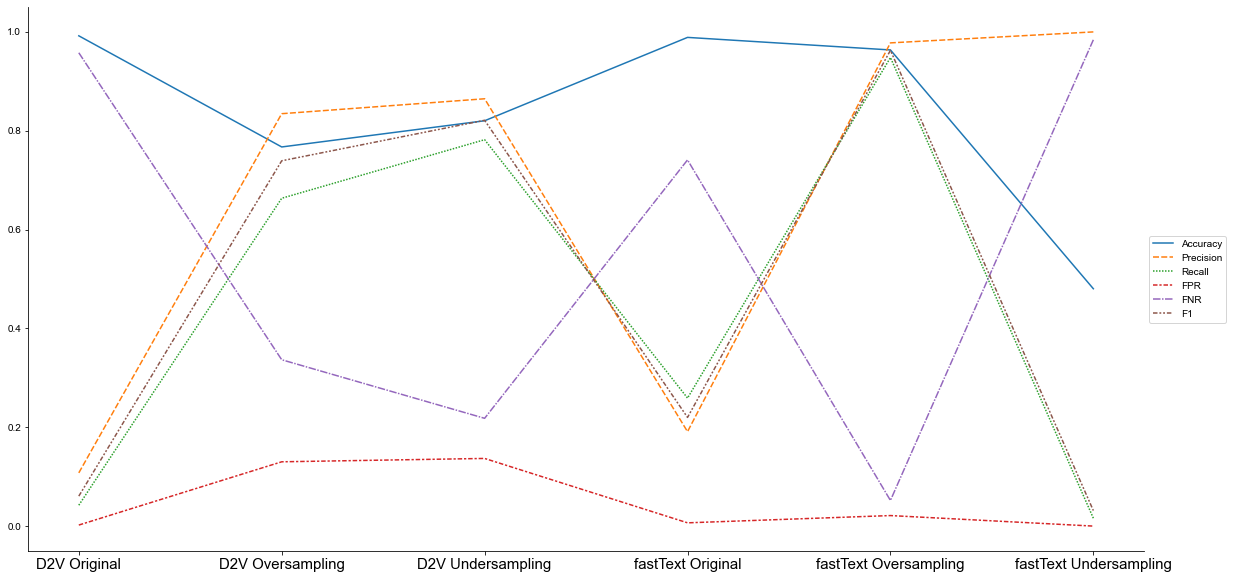

In [153]:
fig, ax = plt.subplots(figsize=(20, 10))

g = sns.lineplot(data=final_stats_cpy)
g.set_xticks(range(len(experiment))) # <--- set the ticks first
g.set_xticklabels(experiment, size = 15)
#g.set_yticklabels(g.get_yticks(), size = 15)
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
sns.despine()
sns.set_style("white")

g.figure.savefig("/Volumes/Research/VulnerabilityDatasets/Vulnerability_datasets/code/ghidra/cb_multios_stats_final_combined_28April21.png")

In [154]:
final_stats_cpy_t = final_stats_cpy.T
final_stats_cpy_t

,0,1,2,3,4,5
Dataset,D2V Original,D2V Oversampling,D2V Undersampling,fastText Original,fastText Oversampling,fastText Undersampling
Accuracy,0.9921,0.7672,0.8202,0.9889,0.9635,0.4803
Precision,0.1077,0.8345,0.8647,0.1911,0.9778,1.0000
Recall,0.0422,0.6634,0.7819,0.2590,0.9481,0.0160
FPR,0.0021,0.1301,0.1369,0.0066,0.0213,0.0000
FNR,0.9578,0.3366,0.2181,0.7410,0.0519,0.9840
F1,0.0606,0.7392,0.8212,0.2199,0.9627,0.0314


In [156]:
final_stats_cpy_t.columns = experiment

In [157]:
t_columns = ['Accuracy', 
            'Precision', 
            'Recall', 
            'FPR', 
            'FNR',
            'F1']

In [158]:
final_stats_cpy_t = final_stats_cpy_t.drop('Dataset')

In [159]:
final_stats_cpy_t = final_stats_cpy_t.reset_index()

In [160]:
final_stats_cpy_t.rename(columns={'index':'Metric'}, inplace=True)

In [161]:
final_stats_cpy_t

,Metric,D2V Original,D2V Oversampling,D2V Undersampling,fastText Original,fastText Oversampling,fastText Undersampling
0,Accuracy,0.9921,0.7672,0.8202,0.9889,0.9635,0.4803
1,Precision,0.1077,0.8345,0.8647,0.1911,0.9778,1.0000
2,Recall,0.0422,0.6634,0.7819,0.2590,0.9481,0.0160
3,FPR,0.0021,0.1301,0.1369,0.0066,0.0213,0.0000
4,FNR,0.9578,0.3366,0.2181,0.7410,0.0519,0.9840
5,F1,0.0606,0.7392,0.8212,0.2199,0.9627,0.0314


In [166]:
perfect_score = [1.0,
                 1.0,
                 1.0, 
                 0.0, 
                 0.0, 
                 1.0]

In [162]:
final_stats_cpy_t['D2V Original'] = final_stats_cpy_t['D2V Original'].astype(float)
final_stats_cpy_t['D2V Oversampling'] = final_stats_cpy_t['D2V Oversampling'].astype(float)
final_stats_cpy_t['D2V Undersampling'] = final_stats_cpy_t['D2V Undersampling'].astype(float)
final_stats_cpy_t['fastText Original'] = final_stats_cpy_t['fastText Original'].astype(float)
final_stats_cpy_t['fastText Oversampling'] = final_stats_cpy_t['fastText Oversampling'].astype(float)
final_stats_cpy_t['fastText Undersampling'] = final_stats_cpy_t['fastText Undersampling'].astype(float)

In [167]:
final_stats_cpy_t['Perfect Score'] = perfect_score

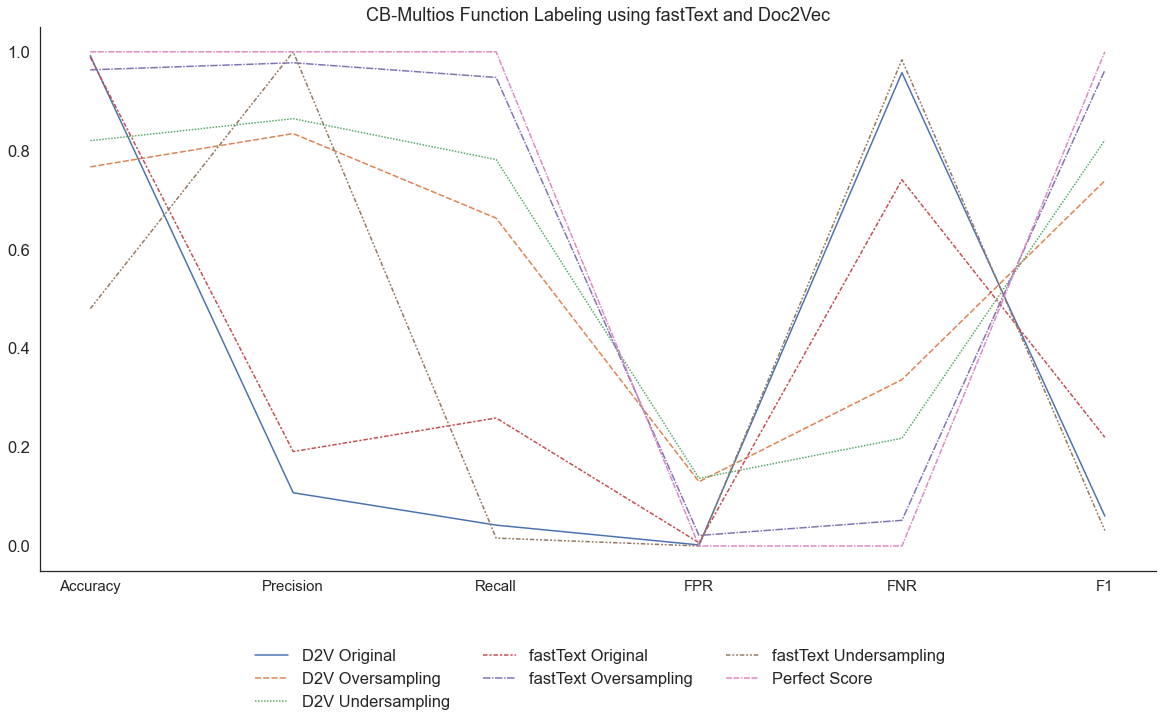

In [191]:
fig, ax = plt.subplots(figsize=(20, 10))

sns.set(font_scale = 1.5)
g = sns.lineplot(data=final_stats_cpy_t)
g.set_xticks(range(len(t_columns))) # <--- set the ticks first
g.set_xticklabels(t_columns, size = 15)
#g.set_yticklabels(g.get_yticks(), size = 15)
g.legend(loc='center left', bbox_to_anchor=(.18, -0.2), ncol=3, frameon=False)
sns.despine()
sns.set_style("white")
g.set_title("CB-Multios Function Labeling using fastText and Doc2Vec")

g.figure.savefig("/Volumes/Research/VulnerabilityDatasets/Vulnerability_datasets/code/ghidra/cb_multios_final_combinedT_28April21.png", bbox_inches='tight')

In [204]:
df = pd.melt(final_stats_cpy_t, id_vars="Metric", var_name="Dataset", value_name="Score")
df

,Metric,Dataset,Score
0,Accuracy,D2V Original,0.9921
1,Precision,D2V Original,0.1077
2,Recall,D2V Original,0.0422
3,FPR,D2V Original,0.0021
4,FNR,D2V Original,0.9578
5,F1,D2V Original,0.0606
6,Accuracy,D2V Oversampling,0.7672
7,Precision,D2V Oversampling,0.8345
8,Recall,D2V Oversampling,0.6634
9,FPR,D2V Oversampling,0.1301


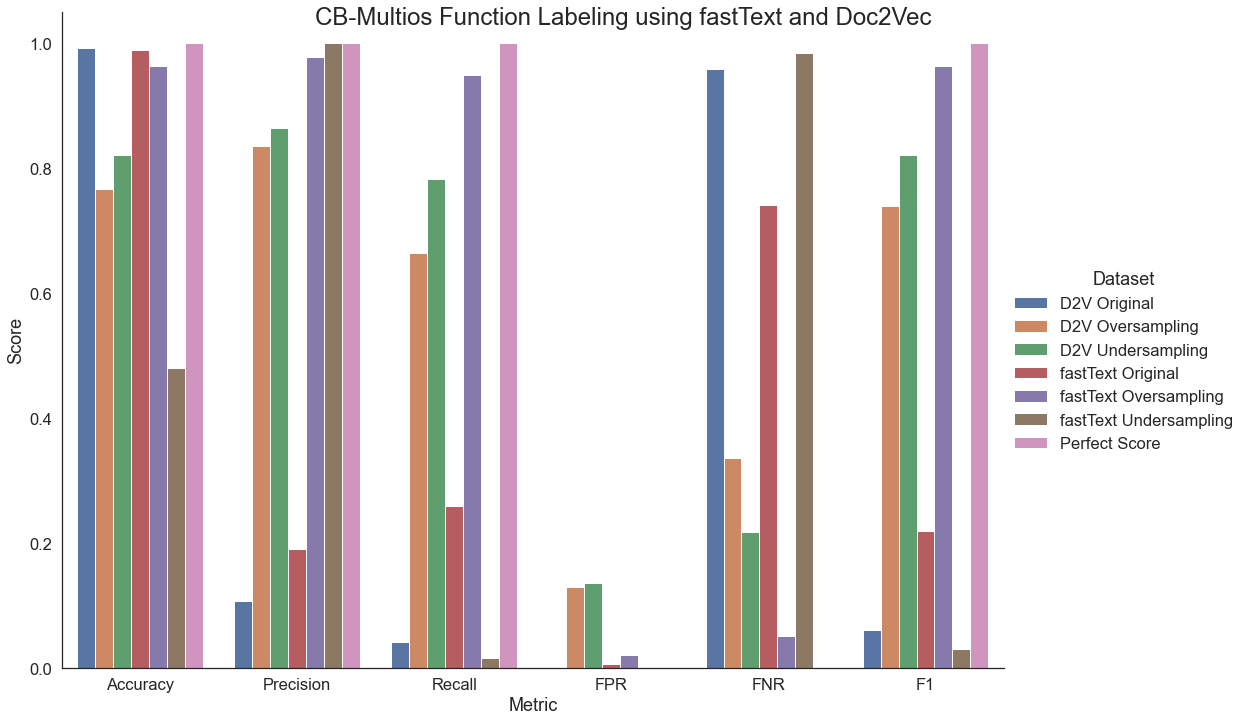

In [228]:

#fig, ax = plt.subplots(figsize=(20, 10))

sns.set(font_scale = 1.5)
sns.set_style(style='white') 
bar = sns.catplot(x='Metric', y='Score', hue='Dataset', data=df, kind='bar',  height=10, aspect=11.7/8.27)
bar.fig.suptitle("CB-Multios Function Labeling using fastText and Doc2Vec",
                  fontsize=24, fontdict={"weight": "bold"})

#g.set_xticks(range(len(t_columns))) # <--- set the ticks first
#g.set_xticklabels(t_columns, size = 15)
#g.set_yticklabels(g.get_yticks(), size = 15)
#g.legend(loc='center left', bbox_to_anchor=(.18, -0.2), ncol=3, frameon=False)
sns.despine()

bar.savefig("/Volumes/Research/VulnerabilityDatasets/Vulnerability_datasets/code/ghidra/cb_multios_final_combinedTBAR_28April21.png", bbox_inches='tight')